visited bins: 198 | ΔE=0.05
total steps (chain tip): 50,000,000
current _m (ln f): 1.52588e-05  (target ≈ 1e-7)
stage histogram sum: 5530000 | cumulative occurrences sum: 50000000
sample capture: 198 bins with samples
bins filled to quota (5): 198
total stored samples: 990  (avg 5.00 per sampled bin)


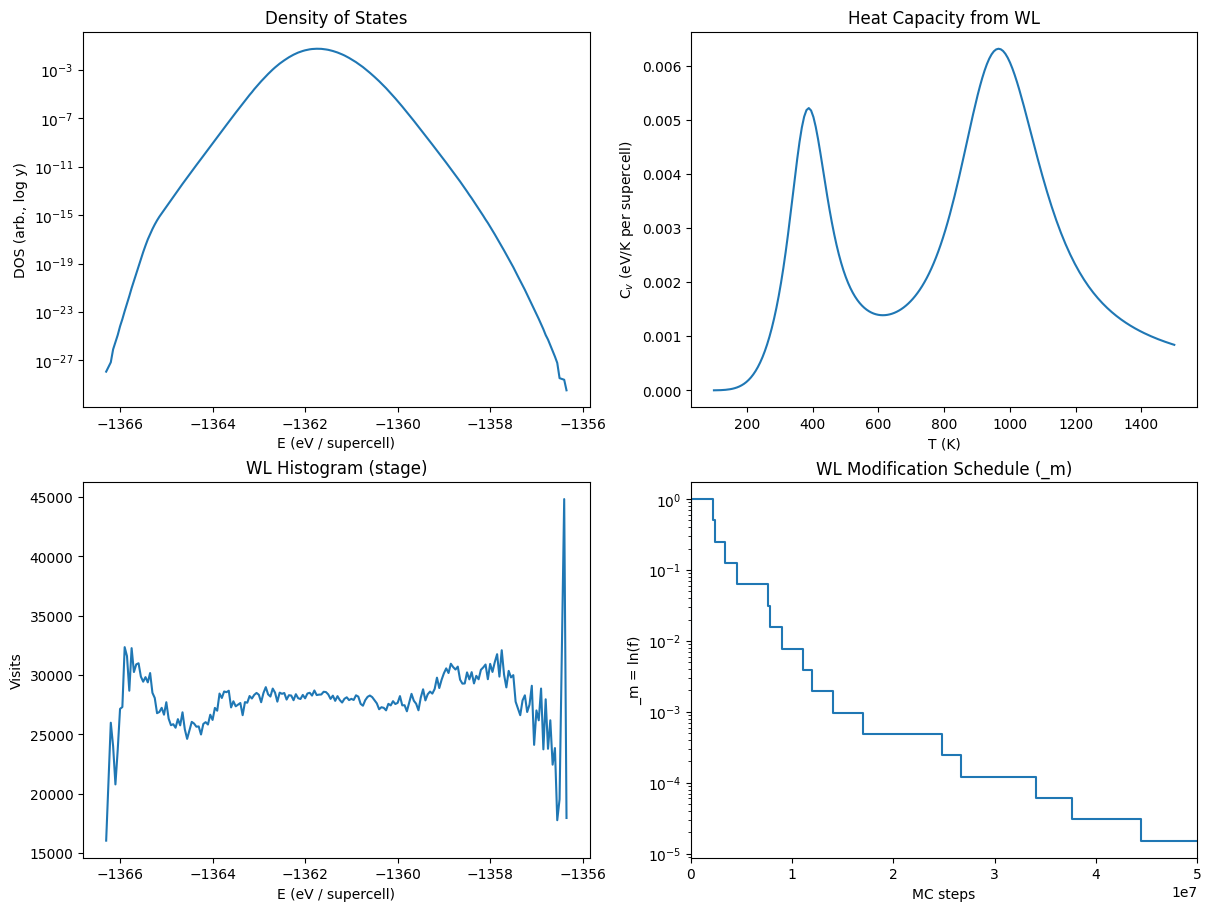

In [7]:
from typing import Any, Mapping, TypedDict, List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from phaseedge.storage import store
from phaseedge.storage.wl_checkpoint_store import get_tip


# ----------------------------- types ---------------------------------------

class WLData(TypedDict):
    levels: np.ndarray
    entropy: np.ndarray
    histogram: np.ndarray          # stage-local (resets at flatness)
    occurrences: np.ndarray        # cumulative (never resets; may be absent in older ckpts)
    bin_indices: np.ndarray
    dE: float
    anchor: float
    m_log: float                   # current _m = ln(f)
    checkpoint: Mapping[str, Any]


# ----------------------------- loaders ------------------------------------

def load_wl_latest_from_chain(wl_key: str) -> WLData:
    checkpoint = get_tip(wl_key)
    if not checkpoint:
        raise RuntimeError(f"No checkpoints found for wl_key={wl_key!r}.")
    s: Mapping[str, Any] = checkpoint["state"]

    bins: np.ndarray = np.asarray(s["bin_indices"], dtype=int)
    entropy: np.ndarray = np.asarray(s["entropy"], dtype=float)
    hist: np.ndarray = np.asarray(s["histogram"], dtype=int)
    occs_raw = s.get("occurrences", [])
    occs: np.ndarray = (
        np.asarray(occs_raw, dtype=int)
        if isinstance(occs_raw, (list, tuple))
        else np.zeros_like(hist)
    )

    anchor: float = 0.0
    dE: float = float(s["bin_size"])
    levels: np.ndarray = anchor + dE * bins.astype(float)

    order = np.argsort(bins)
    return WLData(
        levels=levels[order],
        entropy=entropy[order],
        histogram=hist[order],
        occurrences=occs[order] if occs.size else np.zeros_like(hist[order]),
        bin_indices=bins[order],
        dE=dE,
        anchor=anchor,
        m_log=float(s["mod_factor"]),  # _m = ln(f)
        checkpoint=checkpoint,
    )


def load_mod_schedule(wl_key: str, m0: float = 1.0) -> Tuple[np.ndarray, np.ndarray]:
    """Concatenate per-checkpoint updates into a global schedule of _m (ln f)."""
    coll = store.db_rw()["wang_landau_ckpt"]
    ckpts = list(coll.find({"wl_key": wl_key}, sort=[("step_end", 1)]))
    if not ckpts:
        raise RuntimeError("No checkpoints found.")

    # Prefer the recorded initial m from the first checkpoint, else fallback to 1.0
    m0 = float(ckpts[0]["state"].get("mod_factor", m0))

    events: List[Tuple[int, float]] = []
    for doc in ckpts:
        # New schema: top-level mod_updates
        for ev in doc.get("mod_updates", []):
            events.append((int(ev["step"]), float(ev["m"])))

    if events:
        events = sorted(set(events), key=lambda t: t[0])
        steps = [0] + [st for (st, _) in events]
        m_vals = [m0] + [m for (_, m) in events]
    else:
        tip_steps = int(ckpts[-1]["step_end"])
        steps = [0, tip_steps]
        m_vals = [m0, m0]

    return np.asarray(steps, dtype=int), np.asarray(m_vals, dtype=float)


def _extend_stair_to(steps: np.ndarray, vals: np.ndarray, right_x: int) -> tuple[np.ndarray, np.ndarray]:
    """Ensure a step curve extends horizontally to right_x."""
    if steps.size == 0:
        return np.array([0, right_x], dtype=int), np.array([1.0, 1.0], dtype=float)
    if steps[-1] < right_x:
        steps = np.append(steps, right_x)
        vals  = np.append(vals,  vals[-1])
    return steps, vals


# ----------------------------- analysis + plotting ------------------------

def analyze_wl_chain(wl_key: str) -> None:
    wl = load_wl_latest_from_chain(wl_key)
    levels  = wl["levels"]
    entropy = wl["entropy"]
    hist    = wl["histogram"]
    occ_all = wl["occurrences"]
    dE      = wl["dE"]
    steps_total = wl["checkpoint"]["step_end"]
    m_current = wl["m_log"]
    steps_m, m_vals = load_mod_schedule(wl_key)

    # DOS from entropy
    S_shift: np.ndarray = entropy - np.max(entropy) if entropy.size else entropy
    DOS: np.ndarray = np.exp(S_shift) if S_shift.size else np.array([])
    if DOS.size:
        DOS /= DOS.sum()

    # Cv(T)
    kB: float = 8.617333262e-5  # eV/K
    E:  np.ndarray = levels.astype(float)
    E_rr: np.ndarray = E - E.min() if E.size else E
    Ts: np.ndarray = np.linspace(100.0, 1500.0, 200)

    def _weights(T: float) -> np.ndarray:
        return np.exp(S_shift - E_rr / (kB * T))

    if E.size:
        Z  = np.array([_weights(T).sum() for T in Ts])
        U  = np.array([(_weights(T) * E).sum() / Z[i] for i, T in enumerate(Ts)])
        U2 = np.array([(_weights(T) * E * E).sum() / Z[i] for i, T in enumerate(Ts)])
        Cv = (U2 - U * U) / (kB * Ts * Ts)
    else:
        Z = U = U2 = Cv = np.array([])

    # ---- reporting ----
    print(f"visited bins: {levels.size} | ΔE={dE}")
    print(f"total steps (chain tip): {steps_total:,}")
    print(f"current _m (ln f): {m_current:.6g}  (target ≈ 1e-7)")
    print(f"stage histogram sum: {int(hist.sum())} | cumulative occurrences sum: {int(occ_all.sum())}")

    # ---- sample statistics (new schema: top-level fields) ----
    bin_samples = wl["checkpoint"].get("bin_samples", [])
    samples_per_bin = int(wl["checkpoint"]["samples_per_bin"])

    if bin_samples and samples_per_bin > 0:
        bins_to_occ: Dict[int, List[list[int]]] = defaultdict(list)
        for rec in bin_samples:
            try:
                b = int(rec["bin"])
                occ = rec["occ"]
            except Exception:
                continue
            bins_to_occ[b].append(occ)

        n_bins_with_samples = len(bins_to_occ)
        n_bins_full = sum(1 for occs in bins_to_occ.values() if len(occs) >= samples_per_bin)
        total_samples = sum(len(v) for v in bins_to_occ.values())
        mean_per_sampled_bin = (total_samples / n_bins_with_samples) if n_bins_with_samples else 0.0

        print(f"sample capture: {n_bins_with_samples} bins with samples")
        print(f"bins filled to quota ({samples_per_bin}): {n_bins_full}")
        print(f"total stored samples: {total_samples}  (avg {mean_per_sampled_bin:.2f} per sampled bin)")
    else:
        print("sample capture: none recorded in this checkpoint")

    # ---- plotting ----
    fig, axs = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)

    ax = axs[0, 0]
    if DOS.size:
        eps = 0.0 if np.all(DOS > 0) else 1e-300
        ax.semilogy(E, DOS + eps)
    ax.set_xlabel("E (eV / supercell)")
    ax.set_ylabel("DOS (arb., log y)")
    ax.set_title("Density of States")

    ax = axs[0, 1]
    if Cv.size:
        ax.plot(Ts, Cv)
    ax.set_xlabel("T (K)")
    ax.set_ylabel("C$_v$ (eV/K per supercell)")
    ax.set_title("Heat Capacity from WL")

    ax = axs[1, 0]
    y_visits = hist if hist.sum() > 0 else occ_all
    label = "Histogram (stage)" if y_visits is hist else "Occurrences (cumulative)"
    if y_visits.size:
        ax.plot(E, y_visits)
    ax.set_xlabel("E (eV / supercell)")
    ax.set_ylabel("Visits")
    ax.set_title(f"WL {label}")

    ax = axs[1, 1]
    right_x = max(int(steps_total), int(steps_m[-1]) if steps_m.size else 0)
    steps_m_ext, m_vals_ext = _extend_stair_to(steps_m, m_vals, right_x)
    ax.step(steps_m_ext, m_vals_ext, where="post")
    ax.set_xlim(0, right_x)
    ax.set_xlabel("MC steps")
    ax.set_ylabel("_m = ln(f)")
    ax.set_yscale('log')
    ax.set_title("WL Modification Schedule (_m)")

    plt.show()


# ----------------------------- run ----------------------------------------

# Replace with your WL key:
analyze_wl_chain("78c3ba04732425012a68216c8fe21baf5e0c1243b6f1b8003666fbe853011a73")
